## 3. Optimization

In this section, we explore a few optimization methods to make the sampler more efficient.

In [1]:
import setuptools

S:\Anaconda\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


Make sure the package is installed. Import functions from the package. 

In [2]:
pip install STA-663-IBP==0.1

Note: you may need to restart the kernel to use updated packages.


In [3]:
from example_pkg.IBP_Sampler import IBP, log_likelyhood, sampler
import numpy as np
import scipy.stats as stats
import math
from PIL import Image
import matplotlib.pyplot as plt

To test the performance, we used the example images used in Ilker Yildirim’s paper as my simulation data set (Yildirim 2012).

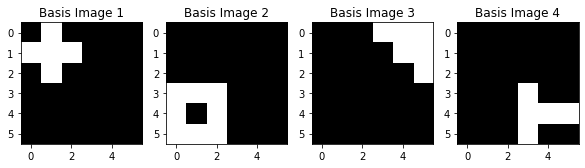

In [4]:
np.random.seed(1)
#We have 4 basis images:
N = 100
D = 36
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4,figsize = (10,4))
b1 = np.array([[0,1,0,0,0,0],
               [1,1,1,0,0,0],
               [0,1,0,0,0,0],
               [0,0,0,0,0,0],
               [0,0,0,0,0,0],
               [0,0,0,0,0,0]])

ax1.imshow(b1,cmap = "gray")
ax1.set_title("Basis Image 1")


b2 = np.array([[0,0,0,0,0,0],
               [0,0,0,0,0,0],
               [0,0,0,0,0,0],
               [1,1,1,0,0,0],
               [1,0,1,0,0,0],
               [1,1,1,0,0,0]])

ax2.imshow(b2,cmap = "gray")
ax2.set_title("Basis Image 2")


b3 = np.array([[0,0,0,1,1,1],
               [0,0,0,0,1,1],
               [0,0,0,0,0,1],
               [0,0,0,0,0,0],
               [0,0,0,0,0,0],
               [0,0,0,0,0,0]])

ax3.imshow(b3,cmap = "gray")
ax3.set_title("Basis Image 3")

b4 = np.array([[0,0,0,0,0,0],
               [0,0,0,0,0,0],
               [0,0,0,0,0,0],
               [0,0,0,1,0,0],
               [0,0,0,1,1,1],
               [0,0,0,1,0,0]])

ax4.imshow(b4,cmap = "gray")
ax4.set_title("Basis Image 4")
pass

b1 = b1.reshape(D)
b2 = b2.reshape(D)
b3 = b3.reshape(D)
b4 = b4.reshape(D)
sigmaX = 0.5

#Create X from basis vectors
zb1 = np.outer(np.random.binomial(1,.5,100),b1)
zb2 = np.outer(np.random.binomial(1,.5,100),b2)
zb3 = np.outer(np.random.binomial(1,.5,100),b3)
zb4 = np.outer(np.random.binomial(1,.5,100),b4)

X = zb1 + zb2 + zb3 + zb4
#Add noise
X = X + np.random.normal(0,sigmaX,(N,D))

### 3.1 Profile

We adopt the decorator from a post on Medium written by Farhad Malik (Malik 2020) to profile our original python code.  

In [5]:
import cProfile
import functools
import pstats
import tempfile
def profile_me(func):
    @functools.wraps(func)
    def wraps(*args, **kwargs):
        file = tempfile.mktemp()
        profiler = cProfile.Profile()
        profiler.runcall(func, *args, **kwargs)
        profiler.dump_stats(file)
        metrics = pstats.Stats(file)
        metrics.strip_dirs().sort_stats('time').print_stats(10)
    return wraps

In [6]:
@profile_me
def sampler(X,alpha,niter,epsilon,sigma_X,sigma_A,alpha_a_prior,alpha_b_prior,max_new):
    '''
    This function performs a Gibbs sampler using the binary matrix Z generated by Indian buffet process and a 
    log likelihood function for the linear-Gaussian bindary latent feature model.
    
    The parameters are:
    
    X: Data matrix
    
    alpha: parameter for the Possion distribution that is used to generate a binary matrix Z using Indian buffet process
    
    niter: The number of iterations for the sampler
    
    Sigma_X: Standard deviation of X
    
    Sigma_A: Standard deviation of alpha
    
    alpha_a_prior: Shape hyperparameter for the prior distribution of alpha, which follows a Gamma distribution.
    
    alpha_b_prior: Rate hyperparameter for the prior distribution of alpha, which follows a Gamma distribution.

    max_new: Maximum number of new K's per iteration
    
    '''
    N = X.shape[0]
    D = X.shape[1]
    Z = IBP(alpha,N) # set inital Z
    K = Z.shape[1]
    K_values = np.zeros(niter)
    alpha_values = np.zeros(niter)
    Sigma_X_values = np.zeros(niter)
    Sigma_A_values = np.zeros(niter)
    HN = 0
    for i in range(1,N+1):
        HN += 1.0/i
    for runs in range(niter):
        for i in range(N):
            for j in range(K):
                #Sample Z given conditionals
                
                col_k_count = sum(Z[:,j]) - Z[i,j] #p(zik|z-ik) = 0 so we set to 0
                if col_k_count == 0:
                    Z[i,j] = 0
                    
                else:
                    Z[i,j] = 0
                    Z0_p = log_likelyhood(X,N,D,K,sigma_X,sigma_A,Z) + np.log(N - col_k_count)
                    Z[i,j] = 1
                    Z1_p = log_likelyhood(X,N,D,K,sigma_X,sigma_A,Z) + np.log(col_k_count)
                    L = Z1_p - Z0_p
                    if L > 40: #helps with overflow
                        Z[i,j] = 1
                    elif L < -40:
                        Z[i,j] = 0
                    elif np.exp(L)/(1 + np.exp(L)) > np.random.random():
                        Z[i,j] = 1
                    else:
                        Z[i,j] = 0
                        
            #Sample to see if new columns get added
            log_prob = np.zeros(max_new)
            a_N = alpha/N
            log_prob[0] = -a_N + log_likelyhood(X,N,D,Z.shape[1],sigma_X,sigma_A,Z)
            for new_ks in range(1,max_new):
                new_cols = np.zeros((N,new_ks))
                new_cols[i,:] = 1
                Z_new = np.hstack((Z,new_cols))
                #Poisson(alpha/n) * log likelyhood
                log_prob[new_ks] = new_ks*np.log(a_N) - a_N - np.log(math.factorial(new_ks)) + log_likelyhood(X,N,D,Z_new.shape[1],sigma_X,sigma_A,Z_new)
            #Convert log likelyhoods
            prob = np.exp(log_prob - max(log_prob))
            prob = prob/sum(prob)

            #Sample probabilites and add columns accordingly
            new_cols_add = list(np.random.multinomial(1,prob) == 1).index(1)
            col_k_count = np.sum(Z,axis = 0) - Z[i,:]
            if new_cols_add == 0:
                Z = Z[:,col_k_count != 0]
            else:
                newcols = np.zeros((N,new_cols_add))
                newcols[i,:] = 1
                Z = np.hstack((Z[:,col_k_count != 0],newcols))
            K = Z.shape[1]
        
        #Part2
        current_likelyhood = log_likelyhood(X,N,D,K,sigma_X,sigma_A,Z) 
        
        #Sigma_X
        sigma_X_new = sigma_X + np.random.uniform(-epsilon,epsilon)
        new_likelyhood = log_likelyhood(X,N,D,K,sigma_X_new,sigma_A,Z)
        if new_likelyhood - current_likelyhood >= 0:
            sigma_X = sigma_X_new
        elif np.exp(new_likelyhood - current_likelyhood) > np.random.random():
            sigma_X = sigma_X_new
        else:
            sigma_X = sigma_X
            
        #Sigma_A
        sigma_A_new = sigma_A + np.random.uniform(-epsilon,epsilon)
        new_log_likelyhood = log_likelyhood(X,N,D,K,sigma_X,sigma_A_new,Z)
        if new_likelyhood - current_likelyhood >= 0:
            sigma_A = sigma_A_new
        elif np.exp(new_likelyhood - current_likelyhood) > np.random.random():
            sigma_A = sigma_A_new
        else:
            sigma_A = sigma_A
         
        #Alpha
        alpha = np.random.gamma(alpha_a_prior + K,alpha_b_prior + 1/(1 + HN))
        
        K_values[runs] = K
        alpha_values[runs] = alpha
        Sigma_X_values[runs] = sigma_X
        Sigma_A_values[runs] = sigma_A
        # print(runs,K,sigma_X)
    return(K_values,alpha_values,Sigma_X_values,Sigma_A_values,Z)

In [7]:
np.random.seed(10)
sampler(X,1,1000,.05,1,1,1,1,4)

Mon Apr 26 20:29:07 2021    C:\Users\peyto\AppData\Local\Temp\tmpqrij47xi

         60448050 function calls (59847646 primitive calls) in 178.538 seconds

   Ordered by: internal time
   List reduced from 65 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   979552   78.063    0.000  142.160    0.000 IBP_Sampler.py:43(log_likelyhood)
        1   15.430   15.430  178.538  178.538 <ipython-input-6-57a98512a3da>:1(sampler)
   979552    8.844    0.000   17.554    0.000 linalg.py:482(inv)
   979552    7.920    0.000   16.040    0.000 linalg.py:2063(det)
   388480    7.698    0.000    7.698    0.000 {built-in method builtins.sum}
  1959104    7.667    0.000   13.986    0.000 twodim_base.py:154(eye)
   979552    7.096    0.000    7.096    0.000 {method 'trace' of 'numpy.ndarray' objects}
  2359311    6.959    0.000    6.959    0.000 {built-in method numpy.zeros}
4139726/3539322    4.841    0.000   54.407    0.000 {built-in method numpy.co

From the profile above, we can see that most of the runtime was spent on the `log_likelyhood` function. Therefore, we concentrated our energy to explore how to optimize the performance of our `log_likelyhood` function.

### 3.2 Optimization of matrix calculations

First, we explored ways to optimize the `log_likelyhood` function by calculating the determinant and inverse of matrix $\textbf{M}$ differently.

We define a `sampler_test` function that allows us to use different log likelyhood functions as input. We test each method using the same inputs with `niter = 100`.

In [8]:
def sampler_test(X,alpha,niter,epsilon,sigma_X,sigma_A,alpha_a_prior,alpha_b_prior,max_new, log_likelyhood):
    '''
    This function allows users to implement the Gibbs sampler using different log likelihood functions.
    
    The parameters are the same as the sampler function except that we need to input a function for the log_likelyhood function
    
    X: Data matrix
    
    alpha: parameter for the Possion distribution that is used to generate a binary matrix Z using Indian buffet process
    
    niter: The number of iterations for the sampler
    
    Sigma_X: Standard deviation of X
    
    Sigma_A: Standard deviation of alpha
    
    alpha_a_prior: Shape hyperparameter for the prior distribution of alpha, which follows a Gamma distribution.
    
    alpha_b_prior: Rate hyperparameter for the prior distribution of alpha, which follows a Gamma distribution.

    max_new: Maximum number of new K's per iteration
    
    log_likelyhood: a log likelihood function
    
    '''
    N = X.shape[0]
    D = X.shape[1]
    Z = IBP(alpha,N) # set inital Z
    K = Z.shape[1]
    K_values = np.zeros(niter)
    alpha_values = np.zeros(niter)
    Sigma_X_values = np.zeros(niter)
    Sigma_A_values = np.zeros(niter)
    HN = 0
    for i in range(1,N+1):
        HN += 1.0/i
    for runs in range(niter):
        for i in range(N):
            for j in range(K):
                #Sample Z given conditionals
                
                col_k_count = sum(Z[:,j]) - Z[i,j] #p(zik|z-ik) = 0 so we set to 0
                if col_k_count == 0:
                    Z[i,j] = 0
                    
                else:
                    Z[i,j] = 0
                    Z0_p = log_likelyhood(X, N,D,K,sigma_X,sigma_A,Z) + np.log(N - col_k_count)
                    Z[i,j] = 1
                    Z1_p = log_likelyhood(X, N,D,K,sigma_X,sigma_A,Z) + np.log(col_k_count)
                    L = Z1_p - Z0_p
                    if L > 40: #helps with overflow
                        Z[i,j] = 1
                    elif L < -40:
                        Z[i,j] = 0
                    elif np.exp(L)/(1 + np.exp(L)) > np.random.random():
                        Z[i,j] = 1
                    else:
                        Z[i,j] = 0
                        
            #Sample to see if new columns get added
            log_prob = np.zeros(max_new)
            a_N = alpha/N
            log_prob[0] = -a_N + log_likelyhood(X, N,D,Z.shape[1],sigma_X,sigma_A,Z)
            for new_ks in range(1,max_new):
                new_cols = np.zeros((N,new_ks))
                new_cols[i,:] = 1
                Z_new = np.hstack((Z,new_cols))
                #Poisson(alpha/n) * log likelyhood
                log_prob[new_ks] = new_ks*np.log(a_N) - a_N - np.log(math.factorial(new_ks)) + log_likelyhood(X, N,D,Z_new.shape[1],sigma_X,sigma_A,Z_new)
            #Convert log likelyhoods
            prob = np.exp(log_prob - max(log_prob))
            prob = prob/sum(prob)

            #Sample probabilites and add columns accordingly
            new_cols_add = list(np.random.multinomial(1,prob) == 1).index(1)
            col_k_count = np.sum(Z,axis = 0) - Z[i,:]
            if new_cols_add == 0:
                Z = Z[:,col_k_count != 0]
            else:
                newcols = np.zeros((N,new_cols_add))
                newcols[i,:] = 1
                Z = np.hstack((Z[:,col_k_count != 0],newcols))
            K = Z.shape[1]
        
        #Part2
        current_likelyhood = log_likelyhood(X, N,D,K,sigma_X,sigma_A,Z) 
        
        #Sigma_X
        sigma_X_new = sigma_X + np.random.uniform(-epsilon,epsilon)
        new_likelyhood = log_likelyhood(X, N,D,K,sigma_X_new,sigma_A,Z)
        if new_likelyhood - current_likelyhood >= 0:
            sigma_X = sigma_X_new
        elif np.exp(new_likelyhood - current_likelyhood) > np.random.random():
            sigma_X = sigma_X_new
        else:
            sigma_X = sigma_X
            
        #Sigma_A
        sigma_A_new = sigma_A + np.random.uniform(-epsilon,epsilon)
        new_log_likelyhood = log_likelyhood(X, N,D,K,sigma_X,sigma_A_new,Z)
        if new_likelyhood - current_likelyhood >= 0:
            sigma_A = sigma_A_new
        elif np.exp(new_likelyhood - current_likelyhood) > np.random.random():
            sigma_A = sigma_A_new
        else:
            sigma_A = sigma_A
         
        #Alpha
        alpha = np.random.gamma(alpha_a_prior + K,alpha_b_prior + 1/(1 + HN))
        
        K_values[runs] = K
        alpha_values[runs] = alpha
        Sigma_X_values[runs] = sigma_X
        Sigma_A_values[runs] = sigma_A
        
#         if (runs % 100 == 0):
#             print(runs,K,sigma_X)
    return(K_values,alpha_values,Sigma_X_values,Sigma_A_values,Z)

In [9]:
np.random.seed(10)

In [10]:
%timeit -r2 -n2 sampler_test(X,1,100,.05,1,1,1,1,4, log_likelyhood = log_likelyhood)

11.7 s ± 159 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


#### 3.2.1 Replacing `inv` with `solve`

In this approach, we consider replacing the calculation of inverse matrix with linear solve. Our intuition is linear solve may require a smaller complexity than calculating the inverse of matrix $\textbf{M}$. We have to calculate $\textbf{Z} \textbf{M}^{-1} \textbf{Z}^T$. So instead of calculating `Z @ np.linalg.inv(M) @ Z.T`, we tried `Z @ np.linalg.solve(M, Z.T)`.

In [11]:
def log_likelyhood_op_solve(X, N,D,K,sigma_X,sigma_A,Z):
    '''
    Log likelyhood function where inverse function is replaced by linear solve
    '''    
    M = Z.T @ Z + (sigma_X**2/sigma_A**2)*np.eye(K)

    part1 = N*D/2 * np.log(2*np.pi) + (N - K)*D*np.log(sigma_X) + K*D*np.log(sigma_A)+D/2*np.log(np.linalg.det(M))

    part2_inside = np.eye(N) - (Z @ np.linalg.solve(M, Z.T))
    part2 = -1/(2 * sigma_X**2) * np.trace(X.T @ part2_inside @ X)
    return part2 - part1

In [12]:
np.random.seed(10)

In [13]:
%timeit -r2 -n2 sampler_test(X,1,100,.05,1,1,1,1,4, log_likelyhood = log_likelyhood_op_solve)

12.3 s ± 260 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


We found the performance is comparable. Using `np.linalg.solve` may not have a noticeable improvement for the function.

#### 3.2.2 Singular Value Decomposition

We also explored a way of computing the determinant and the inverse matrix using singular value decomposition. Since $\textbf{Z}^T \textbf{Z} + \frac{\sigma_X^2}{\sigma_A^2}\textbf{I}$ is a nonsingular matrix, we can calculate the determinant by calculating the products of the singular values $s$. Once we have $U$ and $V^T$ from the singular value decomposition, we can also calculate the inverse of matrix $\textbf{M}$ as $V D^{-1} U^T$ where $D^{-1}$ is a diagonal matrix with diagonal elements $1/s$.

In [14]:
def log_likelyhood_op_svd(X, N,D,K,sigma_X,sigma_A,Z):
    '''
    Log likelyhood function using singular value decomposition
    '''
    M = Z.T @ Z + np.diag([sigma_X**2/sigma_A**2]*K)
    U, s, Vt = np.linalg.svd(M)
    det_M = np.prod(s)
    part1 = N*D/2 * np.log(2*np.pi) + (N - K)*D*np.log(sigma_X) + K*D*np.log(sigma_A)+D/2*np.log(det_M)
    
    M_inv = Vt.T @ np.diag(1/s) @ U.T
    part2_inside = np.eye(N) - (Z @ M_inv @ Z.T)
    part2 = -1/(2 * sigma_X**2) * np.trace(X.T @ part2_inside @ X)
    return part2 - part1

In [15]:
np.random.seed(10)

In [16]:
%timeit -r2 -n2 sampler_test(X,1,100,.05,1,1,1,1,4, log_likelyhood = log_likelyhood_op_svd)

14.4 s ± 368 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


But the performance is comparable to the original likelyhood function. It may be a bit slower than the original function. This may be due to the computational time required by finding the singular value decomposition. 

#### 3.2.3 Using functools

We also tried to use the `reduce` function from `functools` to see if we can improve the performance. 

In [17]:
from functools import reduce

In [18]:
def log_likelyhood_op_reduce(X, N,D,K,sigma_X,sigma_A,Z):
    '''
    Log likelyhood function using 'reduce' function from functools
    ''' 
    M = Z.T @ Z + np.diag(K*[(sigma_X**2/sigma_A**2)])
    part1 = N*D/2 * np.log(2*np.pi) + (N - K)*D*np.log(sigma_X) + K*D*np.log(sigma_A)+D/2*np.log(np.linalg.det(M))
    part2_inside = np.eye(N) - reduce(np.matmul, [Z, np.linalg.inv(M), Z.T])
    part2 = -1/(2 * sigma_X**2) * np.trace( reduce(np.matmul, [X.T, part2_inside, X]))
    return part2 - part1

In [19]:
np.random.seed(10)

In [20]:
%timeit -r2 -n2 sampler_test(X,1,100,.05,1,1,1,1,4, log_likelyhood = log_likelyhood_op_reduce)

12.3 s ± 17.2 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


Once again, we did not find any noticeable improvement in speed. Therefore, we decide to explore optimization methods using cython and numba with the original `log_likelyhood` function. 

### 3.3 Cython and Numba

Next, we tried to optimize the `log_likelyhood` function using cython. We compared the speed of doing matrix multiplication using the `@` operator in numpy with a matrix multiplication function written in cython. 

In [21]:
%load_ext cython

In [22]:
%%cython

import cython
import numpy as np
from libc.math cimport log, pi

@cython.boundscheck(False)
@cython.wraparound(False)
def matrix_multiply(double[:,:] u, double[:, :] v):
    '''
    Matrix multiplication written in Cython
    '''
    cdef int i, j, k
    cdef int m, n, p
    cdef double temp
    cdef double[:,:] res

    m = u.shape[0]
    n = u.shape[1]
    p = v.shape[1]
    
    res = np.zeros((m,p))

    with cython.nogil: 
        for i in range(m):
            for j in range(p):
                temp = 0
                for k in range(n):
                    temp += u[i,k] * v[k,j]
                res[i,j] = temp

    return res

#### 3.3.1 Comparing the performance of matrix multiplication

First, we compared the performance for matrix multiplication between the `@` operator in numpy and the `matrix_multiply` function we wrote in cython.

In [23]:
# Test the performance of our log_likeyhood function
alpha=1
Z = IBP(alpha,N)

In [24]:
A_1 = np.random.randn(1000,36)
A_2 = np.random.randn(36,1000)

In [25]:
%timeit -r7 -n7 matrix_multiply(A_1,A_2)

28.7 ms ± 674 µs per loop (mean ± std. dev. of 7 runs, 7 loops each)


In [26]:
%timeit -r7 -n7 A_1 @ A_2

2.14 ms ± 310 µs per loop (mean ± std. dev. of 7 runs, 7 loops each)


We found that our `matrix_multiply` function written in cython is much slower than the `@` operator in numpy. Since matrix multiplications take a considerable amount of time in the `log_likelyhood` function, we decided not to use `matrix_multiply` function but wrote a cythonized `log_likelyhood` function using the `matmul` function in numpy. 

#### 3.3.2 Cythonize the `log_likelyhood` function

In [27]:
%%cython

import cython
import numpy as np
from libc.math cimport log, pi

@cython.boundscheck(False)
@cython.wraparound(False)

def log_likelyhood_op_cy(double[:,:] X, int N, int D, int K, double sigma_X, double sigma_A, double[:,:] Z):
    '''
    Log likelyhood function written in cython
    '''
    cdef double[:,:] Zt = Z.T
    cdef double[:,:] Xt = X.T
    cdef double[:,:] M
    cdef double part1
    cdef double part2
    cdef double res

    M = np.matmul(Zt, Z)

    for i in range(M.shape[0]):
        M[i,i] = M[i,i] + sigma_X**2/sigma_A**2

    part1 = N*D/2 * log(2*pi) + (N - K)*D*log(sigma_X) + K*D*log(sigma_A)+D/2*log(np.linalg.det(M))

    M_ZT = np.matmul(np.linalg.inv(M), Z.T)
    part2_inside = np.eye(N) - np.matmul(Z, M_ZT)

    XT_P2 = np.matmul(Xt, part2_inside)
    part2 = -1/(2 * sigma_X**2) * np.trace(np.matmul(XT_P2, X))

    res = part2 - part1

    return res

In [28]:
np.random.seed(10)

In [29]:
%timeit -r2 -n2 sampler_test(X,1,100,.05,1,1,1,1,4, log_likelyhood = log_likelyhood_op_cy)

13.1 s ± 416 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


As we can see from the comparison above, cythonizing the liklyhood function does not outperfrom the original likelyhood function. One of the reasons can be our cython code still depends heavily on functions in the numpy package to compute the determinant and the inverse function. Using numpy functions in cython may create unnecessary overhead. Due to the complex data structures in cython, we chose to stick with the original `likelyhood` function for now.

#### 3.3.3 Numba

We also tried to use numba for our matrix multiplication. 

In [30]:
import numba
from numba import jit

In [31]:
@jit('double[:,:](double[:,:], double[:,:])')
def matrix_multiply_numba2(A, B):
    '''
    Matrix multiplication using numba
    '''
    m, n = A.shape
    n, p = B.shape
    C = np.zeros((m, p))
    for i in range(m):
        for j in range(p):
            d = 0.0
            for k in range(n):
                d += A[i,k] * B[k, j]
            C[i,j] = d
    return C

In [32]:
%timeit -r7 -n7 matrix_multiply_numba2(A_1,A_2)

31.6 ms ± 2.45 ms per loop (mean ± std. dev. of 7 runs, 7 loops each)


From the result above, we can see that the speed of matrix multiplication using numba is much slower than using `@` operator in numpy. We can conclude that numba is not an optimal choice for our algorithm.

### 3.4 Conclusion on optimization

The table below shows a brief summary of the average speed of different methods when we tested them with `niter = 100`.

In [34]:
import pandas as pd

df = pd.DataFrame(dict(Original = 11.7,
                       Linear_solve = 12.3, 
                       SVD = 14.4,
                       Reduce = 12.3,
                       Cython = 13.1),
                  index = ["Speed (seconds)"]
                 )
df


,Original,Linear_solve,SVD,Reduce,Cython
Speed (seconds),11.7,12.3,14.4,12.3,13.1


Based on the results, we did not find any method that provides a significant improvment for the speed of the algorithm. Therefore, we decided to use the original function written with numpy as final algorithm.

### 3.5 Reference

Malik, Farhad. “Advanced Python: Learn How To Profile Python Code.” Medium, FinTechExplained, 20 July 2020, medium.com/fintechexplained/advanced-python-learn-how-to-profile-python-code-1068055460f9. 

Yildirim, Ilker. "Bayesian Statistics: Indian Buffet Process." August 2012, https://www2.bcs.rochester.edu/sites/jacobslab/cheat_sheet/IndianBuffetProcess.pdf